In [2]:
import kwant 
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, asdict
from kwant.continuum import discretize  
sx = np.array([[0 , 1] , [1 , 0]])
sy = np.array([[0 , -1j] , [1j , 0]])
sz = np.array([[1 , 0] , [0 , -1]])
id = np.array([[1 , 0] , [0 , 1]])

%matplotlib widget

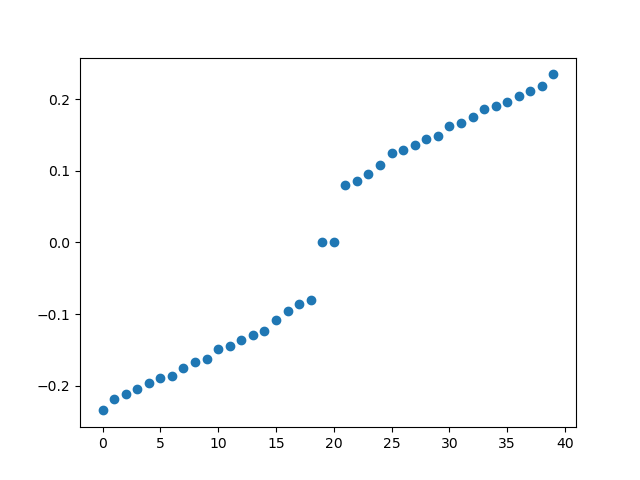

In [68]:
from scipy import constants
from sympy import exp
@dataclass
class parameters:
    a : float # Lattice constant
    L_x : float # Dimension of planar system in x direction
    L_y : float # Dimension of planar system in y direction
    W : float # Width of the normal region in y direction
    m_eff : float # Effective mass
    mu : float # Chemical potential  
    alpha : float # Rashba coupling
    E_z : float # In plane Zeeman
    Delta : float # Superconducting gap
    phase : float # Phase bias of Josephson junction
def make_system_continuum_discretized(params , plot = False):
    
    # Continuum model:
    hamiltonian_bottom = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + 0.5*(m_eff*(alpha**2))*kron(sigma_z, sigma_0) 
    + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) + Delta*kron(sigma_x , sigma_0)"""

    hamiltonian_top = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + 0.5*(m_eff*(alpha**2))*kron(sigma_z, sigma_0) 
    + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) + 0.5*Delta*exp1*kron(sigma_x + I*sigma_y , sigma_0) 
    + 0.5*Delta*exp2*kron(sigma_x - I*sigma_y , sigma_0) 
    """

    template_sc_top = discretize(hamiltonian_top , locals = {'exp1' : np.exp(1j*params.phase) , 'exp2': np.exp(-1j*params.phase) } ,  grid = params.a )
    template_sc_bottom = discretize(hamiltonian_bottom , grid = params.a)
    template_normal = discretize(hamiltonian_bottom , locals =  {'Delta' : 0 , 'E_z' : 0 } , grid = params.a)

    half_w = params.W // 2
    half_L_y = params.L_y // 2

    def normal_region_color(site):
        if normal_region(site) == True:
            return 'red'
        else: 
            return 'blue'

    def normal_region(site):
        (x , y) = site.pos
        return ((half_L_y - half_w)< y < (half_L_y + half_w))   and (0<= x < params.L_x)
    
    def bottom_super_region(site):
        (x , y) = site.pos
        return (0 <=y <= (half_L_y - half_w)) and (0<=x < params.L_x)
    
    def top_super_region(site):
        (x , y) = site.pos
        return ((half_L_y + half_w)  <= y < params.L_y) and (0 <= x < params.L_x)

    # def shape(site):
    #     (x , y) = site.pos
    #     return (0<= x < params.L_x) and (0 <= y < params.L_y)

    syst = kwant.Builder()
    syst.fill(template_sc_bottom , bottom_super_region , (0 , 0) )
    syst.fill(template_normal , normal_region , (0 , (half_L_y - half_w) + 1))
    syst.fill(template_sc_top , top_super_region , (0 , (half_L_y + half_w)))

    if plot == True:
        kwant.plot(syst , site_lw = 0.1 ,  site_color = normal_region_color );
    
    return syst.finalized()

# def make_system(params , plot = False):
#     lat = kwant.lattice.square(a = params.a, norbs = 4)
#     syst = kwant.Builder(particle_hole = np.kron(sy , sy))

#     # Scaled quantitites:
#     l_x = params.L_x // params.a
#     l_y = params.L_y // params.a

#     half_l_y = params.L_y // 2
#     half_w = params.W // 2

#     t = 1/(2*params.m_eff*(params.a**2))
#     for i in range(l_x):
#         for j in range(l_y):

#             syst[lat(i , j)] = 4*t*np.kron(sz , id) + x


params = parameters(a = 0.5 , L_x = 50, L_y = 21 , W  = 2 , m_eff = 0.5 , mu = 2.4 , alpha =1.0 , E_z= 1.0 , Delta = 1.0 , phase = np.pi*1.0 )
syst  = make_system_continuum_discretized(params , plot = False)


import JV_tools as jv
import scipy.sparse.linalg as sla
ham = syst.hamiltonian_submatrix(params = asdict(params) , sparse = True)
# These are various solving and plotting functions:
def solve_me(ham, number):
    eigenvalues , eigenvectors = sla.eigsh(ham , k = number , sigma = 0.0 , which = 'LM')

    idx = np.argsort(np.abs(eigenvalues))
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[: , idx]

    return eigenvalues , eigenvectors

evals , evecs = solve_me(ham , 40)

plt.figure()
plt.scatter(np.arange(len(evals)),evals[np.argsort(evals)])



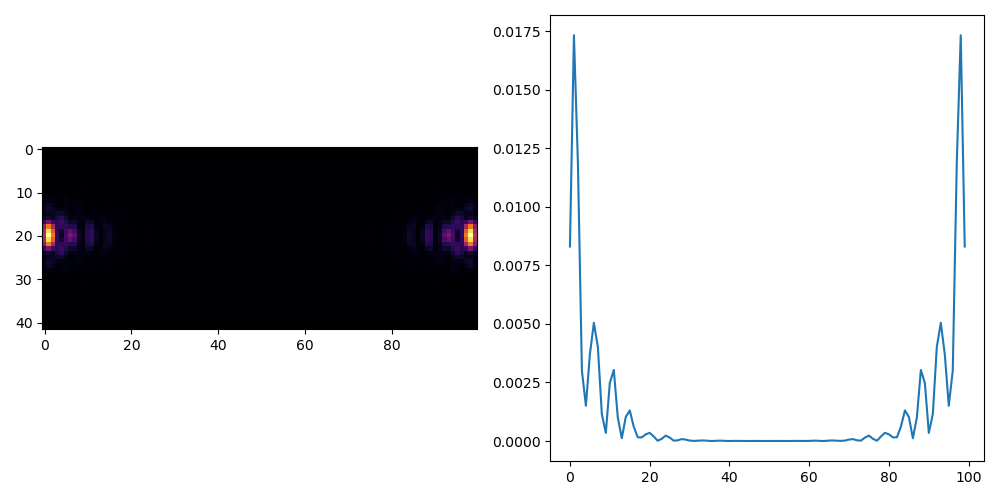

In [70]:
def see_the_funk(k , ev , params):
    psi = ev[: , k]
    innerprod = np.conjugate(psi) * psi
    prob_density = np.array([sum(innerprod[i : i + 4]) for i in range(0 , len(innerprod), 4)])
    wavefunc = np.reshape(prob_density , ((int(params.L_x/params.a)) , int(params.L_y/params.a)))
    return np.real(wavefunc.T)

wf = see_the_funk(0 , evecs , params)
fig , ax = plt.subplots(nrows = 1 , ncols = 2)
fig.set_figwidth(10)
fig.set_figheight(5)
ax[0].imshow(wf , cmap = 'inferno')
ax[1].plot(wf[wf.shape[0]//2 , :])
plt.tight_layout()



In [65]:
# Let's also see if we can reproduce the critical dips as a function of zeeman field:


(42, 100)